In [4]:
#importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns
import plotly.graph_objects as go
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler, label_binarize
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, export_text, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

In [5]:
seed=12345 #fijamos la semilla de aleatorización para que sea la misma en todo el proceso
#Reemplaza con la ruta correcta y nombre de tu archivo
file_path = 'C:/Users/user/OneDrive - Universidad Complutense de Madrid (UCM)/Documentos/Titulo Propio/Machine Learning/Redes Neuronales/Python/SAheart.csv' 
#convertir a data frame el archivo
df = pd.read_csv(file_path)
#La variable de interés es chd, binaria Si/No
#analizamos la frecuencia de cada clase
print(f'\n Instancias: {df.shape[0]}; Variables: {df.shape[1]}')
print(f'\nLa frecuencia de cada clase es: \n{df.chd.value_counts()}')


 Instancias: 462; Variables: 10

La frecuencia de cada clase es: 
No    302
Si    160
Name: chd, dtype: int64


In [6]:
# Si se quiere categorizar la variable de respuesta (útil cuando tiene 1/0)
#df['chd'] = df['chd'].apply(lambda x: 'Yes' if x == 1 else 'No')
#en nuestro caso, cambiamos Si por Yes
df['chd'] = df['chd'].apply(lambda x: 'Yes' if x == 'Si' else 'No')

In [7]:
# hay valores perdidos?
df.isna().sum()

sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

Preparamos la base de datos para la aplicación de redes neuronales:

    - Estandarizar/normalizar variables continuas
    - Convertir a dummies las variables categóricas
    - Evitar missing

In [8]:
# organiza las variables según su rol y naturaleza
# determina variable objetivo
target = "chd"
#hacer una lista con las variables input numericas
num_cols = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
#hacer una lista con las variables input categóricas
cat_cols = ['famhist']

In [9]:
#Convertir a dummies las categóricas
#solo hay una variable categórica, transformación fácil
df[['famhist']] = pd.get_dummies(df[['famhist']],drop_first=True)
#otra opción
cat_cols = ColumnTransformer(transformers=[ ('ohe', OneHotEncoder(drop='first'), cat_cols)], 
                                                  remainder='passthrough')


In [10]:
#Normalizar variables numericas
#Si se quisieran estandarizar, scaler=StandardScaler()
scaler = MinMaxScaler() #selecciona el transformador
X = df[num_cols] #selecciona las variables numéricas que se quieren transformar y las guarda en un nuevo dataframe
X_scale = pd.DataFrame(scaler.fit_transform(X)) #guarda el resultado de la transformación de las variables de X en X_scale
X_scale.columns = X.columns #para simplificar los nombres, asigna a las columnas de X_scale los nombres de las variables de X_num
df[num_cols] = X_scale

`GridSearchCV` es una función de la biblioteca scikit-learn que se utiliza para realizar una búsqueda exhaustiva sobre un conjunto especificado de hiperparámetros para un modelo de aprendizaje automático. La idea es probar todas las combinaciones posibles de hiperparámetros especificados en una cuadrícula y seleccionar la combinación que ofrece el mejor rendimiento según una métrica determinada.

1. **Definición del Modelo:** Se selecciona un modelo junto con un conjunto de hiperparámetros para optimizar. Los hiperparámetros son configuraciones ajustables que afectan el rendimiento y el comportamiento del modelo.

2. **Definición de la Cuadrícula/Rejilla de Parámetros:** Se especifican los valores posibles para cada hiperparámetro que se desea ajustar. `GridSearchCV` probará todas las combinaciones posibles de estos valores.

3. **División de Datos:** Los datos se dividen en conjuntos de entrenamiento y prueba. Durante la búsqueda de la cuadrícula, el modelo se ajusta a los datos de entrenamiento y se evalúa en el conjunto de prueba.

4. **Evaluación del Rendimiento:** Se elige una métrica de evaluación, como precisión, exactitud, F1-score, etc. (¡depende del problema considerado!). Esta métrica se utilizará para evaluar el rendimiento del modelo en cada combinación de hiperparámetros.

5. **Búsqueda Exhaustiva:** `GridSearchCV` realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros en la cuadrícula. Ajusta el modelo con cada combinación y evalúa su rendimiento utilizando la métrica especificada.

6. **Selección del Mejor Modelo:** Una vez que se han probado todas las combinaciones, `GridSearchCV` selecciona la combinación de hiperparámetros que proporcionó el mejor rendimiento según la métrica elegida.

`GridSearchCV` automatiza el proceso de ajuste de hiperparámetros al probar sistemáticamente diferentes combinaciones, lo que facilita la identificación de la configuración óptima para un modelo en particular.

`refit` es un parámetro que determina si ajustar o no el estimador final utilizando los mejores hiperparámetros encontrados durante la búsqueda en la cuadrícula.

Cuando refit está establecido en True (que es el valor predeterminado), después de completar la búsqueda en la cuadrícula, GridSearchCV ajustará automáticamente el estimador utilizando los mejores hiperparámetros encontrados en todo el conjunto de datos de entrenamiento.

**IMPORTANTE** el valor añadido de un analista es encontrar el equilibrio entre la calidad del modelo y su complejidad, las necesidades y requerimientos de cada problema, el mantenimiento y cuidado que se le podrá prestar al modelo, etc. Limitarse al "mejor modelo" propocionado por GridSearchCV sería nuestro final como analistas. Es IMPRESCINDIBLE ir más allá de la parametrización que optimiza numéricamente la medida de bondad escogida.

In [16]:
# Tuneo y evaluación predictiva del modelo para variable dependiente continua
# El grupo de variables predictoras se define y se fija
X = df[['famhist','tobacco','alcohol']] #en X las variables ya están normalizadas y con dummies
y = df['chd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
red = MLPClassifier()
#definimos los parámetros que queremos tunear
params = {
    'max_iter': [600],
    'hidden_layer_sizes': [5,7,9],
    'activation': ['tanh','relu'],
    'alpha': [0.001,0.0001]
}
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
# cv = crossvalidation con n folds con todas las combinaciones de parámetros
grid_search = GridSearchCV(estimator=red, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')

#ajusta en entrenamiento con todas las combinaciones
grid_search.fit(X_train, y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

GridSearchCV(cv=4, estimator=MLPClassifier(),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.001, 0.0001],
                         'hidden_layer_sizes': [5, 7, 9], 'max_iter': [600]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

In [18]:
# Obtener resultados del grid search
results = pd.DataFrame(grid_search.cv_results_)
# Mostrar resultados
print("Resultados de Grid Search:")
print(results[['params', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_recall_macro', 'mean_test_f1_macro']])
#print(results) #para ver todos los atributos obtenidos y entender cómo usarlos

# Obtener el mejor modelo (en cuanto a optimización del criterio)
best_model = grid_search.best_estimator_
print(grid_search.best_estimator_)

Resultados de Grid Search:
                                               params  mean_test_accuracy  \
0   {'activation': 'tanh', 'alpha': 0.001, 'hidden...            0.712892   
1   {'activation': 'tanh', 'alpha': 0.001, 'hidden...            0.718239   
2   {'activation': 'tanh', 'alpha': 0.001, 'hidden...            0.710086   
3   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...            0.710057   
4   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...            0.723673   
5   {'activation': 'tanh', 'alpha': 0.0001, 'hidde...            0.715521   
6   {'activation': 'relu', 'alpha': 0.001, 'hidden...            0.699217   
7   {'activation': 'relu', 'alpha': 0.001, 'hidden...            0.704681   
8   {'activation': 'relu', 'alpha': 0.001, 'hidden...            0.715521   
9   {'activation': 'relu', 'alpha': 0.0001, 'hidde...            0.677565   
10  {'activation': 'relu', 'alpha': 0.0001, 'hidde...            0.704652   
11  {'activation': 'relu', 'alpha': 0.0001, 'hidd

In [13]:
# se seleccionan los modelos candidatos, y analiza su robustez a lo largo de cross validation.
ac_1 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]
ac_2 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[5]
ac_3 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[8]

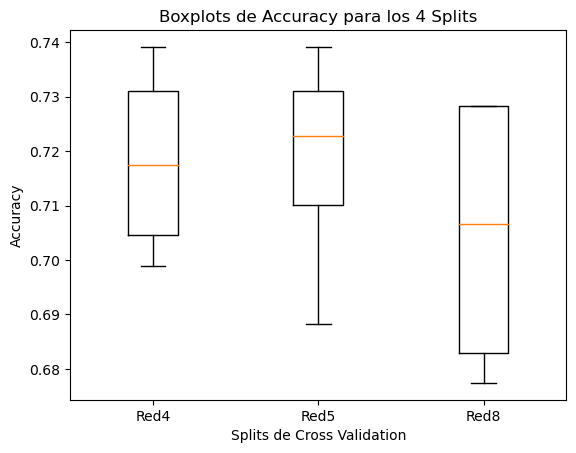

In [14]:
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([ac_1.values,ac_2.values,ac_3.values], labels = ['Red4','Red5','Red8'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Área bajo la curva ROC (AUC) para la red 4 en test: 0.69


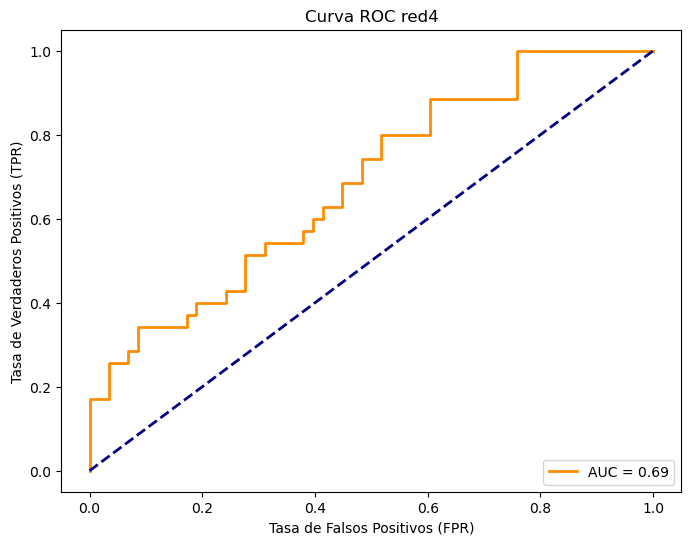

In [41]:
#analizar y reentrenar redes candidatas AUC
X = df[['famhist','tobacco','alcohol']] #en X las variables ya están normalizadas y con dummies
y = df['chd']
y_auc = pd.get_dummies(y,drop_first=True) #para calcular el AUC, y debe ser numérica

X_train, X_test, y_train, y_test = train_test_split(X, y_auc, test_size=0.2, random_state=seed)


red4 = MLPClassifier(**results.iloc[4].params)
red5 = MLPClassifier(**results.iloc[5].params)
red8 = MLPClassifier(**results.iloc[8].params)

# Ajustamos NOTA: NO se ajusta la muestra de test
#red4.fit(X_test, y_test)
#red5.fit(X_test, y_test)
#red8.fit(X_test, y_test)
# Fit the models
red4.fit(X_train, y_train)
red5.fit(X_train, y_train)
red8.fit(X_train, y_train)

# Calculamos las predicciones en test, en términos de probabilidad para poder dibujar el AUC
y_pred4 = red4.predict_proba(X_test)[:,1]
y_pred5 = red5.predict_proba(X_test)[:,1]
y_pred8 = red8.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred4)
roc_auc = auc(fpr, tpr)
print(f"\nÁrea bajo la curva ROC (AUC) para la red 4 en test: {roc_auc:.2f}")

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC red4')
plt.legend(loc="lower right")
plt.show()

In [43]:
# medidas de bondad de ajuste en test: ojo, necesitamos la clasificación continua
X = df[['famhist','tobacco','alcohol']] #en X las variables ya están normalizadas y con dummies
y = df['chd']
X_train, X_test, y_train_b, y_test_b = train_test_split(X, y, test_size=0.2, random_state=seed)

# Definimos el modelo
red4 = MLPClassifier(**results.iloc[4].params)

#Ajustamos
red4.fit(X_test, y_test)


#calculamos las predicciones en test, en términos de probabilidad para poder dibujar el AUC
y_pred4 = red4.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred4)
print("Matriz de Confusión:")
print(conf_matrix)
print("\nMedidas de Desempeño:")
print(classification_report(y_test, y_pred4))

C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Matriz de Confusión:
[[57  1]
 [28  7]]

Medidas de Desempeño:
              precision    recall  f1-score   support

           0       0.67      0.98      0.80        58
           1       0.88      0.20      0.33        35

    accuracy                           0.69        93
   macro avg       0.77      0.59      0.56        93
weighted avg       0.75      0.69      0.62        93
